<a href="https://colab.research.google.com/github/bacoco/solar/blob/main/Combined_solar_campfire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Campfire on the Sun
### Final project for AI-3, C4
### Team members: **Loic Baconnier and Aseem Gosain**

For information, our dataset and the presentation videos (in both English and Spanish), you can visit: https://deeplearning.asia/ 

**Introduction:**

The European space agency solar orbiter has had its second close encounter with the Sun and has recently captured video footage of the surface of the Sun with never before seen detail. 
You can find the footage here (2.5 hours of real time compressed to a 87 second video):
[ESA - Solar Orbiter’s unprecedented view of the quiet corona](https://www.esa.int/ESA_Multimedia/Videos/2022/10/Solar_Orbiter_s_unprecedented_view_of_the_quiet_corona)


This movie comes from 13 October, when the spacecraft’s Extreme Ultraviolet Imager (EUI) returned the highest resolution movie of the quiet corona ever taken. This movie shows the dynamic nature of the Sun's million degree-hot corona.

We plan to use this footage to make an unsupervised detector for anomalous solar surface phenomena. One such phenomenon that was revealed by the ESA mission is solar campfires which are small-scale, short-lived, coronal brightenings, and can appear as loop-like, dot-like, or complex structures. They are mostly rooted at the chromospheric network boundaries and their height lies between 1000 and 5000 km above the photosphere.

**Description:**

Our project is planned to be in following phases:

**Phase 1: Data Preparation**

* Decompose the video into images. (100 images here). We use a software to do that for us.
* Images are 2000x2000, very high resolution. Time difference between 2 images is ~1 sec.
* Take this dataset with 100 pictures. First make a centre crop to remove the timestamp -> 1890x1890. This will be the dataset from now.
* Resnet (600x600) and EfficientNetV2L (224x224) is the smallest model calibrated on images. We use EfficientNet.
* Decide a random crop (resize)/transformation and apply the same transformation to all the images of the dataset. Transformation includes  rotation, flipping, brightness. We select (100*117) unique transformations for now. 
* Penultimate layer of efficientnet is 7x7x1280 dimension convolution. We maxpool it to get to 1280 dimension. This is the image  embedding and it is saved.
* Now we have saved the embedding files and the cropped images as pickles. This means we get multiple temporal series of embedding data of length 100. We save the embeddings because running Efficientnet takes a lot of time to make embeddings. 
* We work with a pipeline that separates the data preparation and usage into different notebooks. Later we combine the notebooks into one.

**Phase 2: Model Training**

Phase 2 of the project is training the models to predict the next embedding. We use the following networks for this analysis: 

1. Feed Forward Neural Network (FFNN)
1. Vanilla Recurrent Neural Network (RNN)
1. Gated Recurrent Units (GRU)
1. Long-Short Term Memory Netrowk (LSTM and Bidirectional LSTM)

Sample of 100 is like a paragraph. We can cut it into sentences through 
1. Sliding window approach. The sliding window can be 10, 20, 50 or 70.
2. Skip frames (every second or third frame to reduce temporal resolution)

We thus generate training data with above approaches and target is the next embedding. After the training, we have different applications. 

**Phase 3: Using the Model**

On the test set, we generate test samples using the same approach as above of splitting a paragraph, and we make predictions to get the outlier. Comparing visually the images where the prediction is far from the reality/target. This can help with unsupervised detection of surface anomalies. 

**Bonus Phase: Building a Decoder**

Since it would be nice to be able to convert embeddings back into images, we also build a convolutional decoder and train it with EfficientNetV2L as the encoder to reconstruct the solar images. This is a work in progress because training of such a decoder takes a long time and doesn't yet perform well.

**Final Thoughts:**

This project is aimed at providing a proof-of-concept of an architecture for unsupervised solar anomaly detection. With that in mind, we are currently working with very little data (Originally a 87 sec high resolution video of one patch of the sun’s surface 17 Earths wide) to demonstrate the idea.


# Section 1: Data Preparation and Augmentaiton.

The first step is to decompose the original video into images. We do that using off-the-shelf software like [FFMpeg](https://ffmpeg.org/) and decompose the original video into 100 equally spaced frames and save them on disk.

Now, since the data is very less (only 100 unique sequential images) but of quite high resolution (2048x2048), we have to perform some data augmentation.

In [ ]:
# We will use some third party libraries
# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# !pip install google.colab
!pip install scikit-image
!pip install albumentations

To obtain multiple sets of data, we have to process the same transformation process to all 100 images at the same time. A transformation contains a random crop, a flip and brightness change.

We will not use standard data augmentation from Tensorflow (ImageDataGenerator) because we found that it is very slow in runtime.
We use here Albumentation, an library dealing with image transformation.
We haven't worked with preprocesssing in Data Augmentation because for that we have to change the datagen class, and it didn't work yet..

## Taking a look at the batch (100 images)

In [ ]:
# Fixing directory paths comtaining the 100 images.
directory='/Users/loic/Library/CloudStorage/GoogleDrive-loic@baconnier.com/Mon Drive/AAA_NLP_UNIV.AI/SOLAR/Data/100_pics/original/*.jpg'
directory_out='/Users/loic/Library/CloudStorage/GoogleDrive-loic@baconnier.com/Mon Drive/AAA_NLP_UNIV.AI/SOLAR/Data/100_pics/samples/*.*'


In [ ]:
# from numpy import expand_dims
import tensorflow as tf

from tensorflow.keras.utils  import img_to_array

from matplotlib import pyplot

import pickle
import glob
import random
import pandas as pd
import numpy as np

In [ ]:
# Looking at length of image directory. Just checking it should be 100.
all_list_images=list(glob.glob(directory))
len(all_list_images)

100

In [ ]:
# 3 random images
list_images=random.choices(all_list_images,k=3)
list_images

['/Users/loic/Library/CloudStorage/GoogleDrive-loic@baconnier.com/Mon Drive/AAA_NLP_UNIV.AI/SOLAR/Data/100_pics/original/024.jpg',
 '/Users/loic/Library/CloudStorage/GoogleDrive-loic@baconnier.com/Mon Drive/AAA_NLP_UNIV.AI/SOLAR/Data/100_pics/original/026.jpg',
 '/Users/loic/Library/CloudStorage/GoogleDrive-loic@baconnier.com/Mon Drive/AAA_NLP_UNIV.AI/SOLAR/Data/100_pics/original/012.jpg']

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow,imsave
import numpy as np
images = [imread(c) for c in list_images]

#convenience function to display an image and print its shape
def display(image):
    fig, axes = plt.subplots(ncols=1)
    fig.set_size_inches(2, 2)
    axes.set_axis_off()
    axes.imshow(image)
    plt.tight_layout()
    plt.show()
    print(image.shape)
len(all_list_images)

100

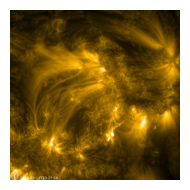

(2048, 2048, 3)


In [ ]:
#first random image.
display(images[0])
original_height, original_width=images[0].shape[:2]

Notice there is a timestamp in the lower left corner of the image, must remove it to process further.

In [ ]:
#sorting by filename (file name is a proxy for time). This way images are in chronological order. 
list_original_image_file=sorted(list(glob.glob(directory)))
len(list_original_image_file)

100

In [ ]:
# Scaling the image component values from 0-255 to 0-1. This will help in further processing. 
list_original_image = [img_to_array(imread(c))/255.0 for c in list_original_image_file]
image_size=(len(list_original_image),224, 224, 3)

Below we look at the first 9 images.

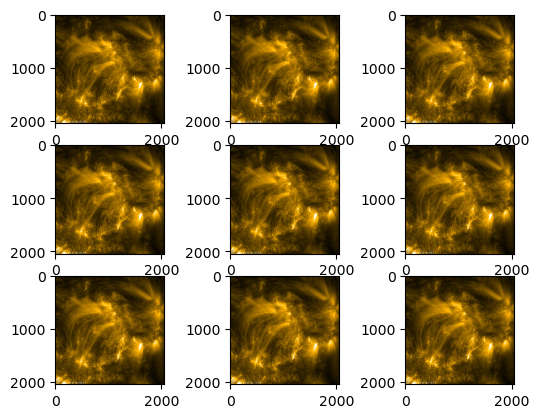

In [ ]:
for i in range(9):
	# define subplot
  pyplot.subplot(330 + 1 + i)
  # image=tf.image.random_crop(value=data_central_crop, size=(600, 600, 3))
  pyplot.imshow(list_original_image[i])
# show the figure
pyplot.show()

In [ ]:
#!pip install yellowbrick
#!pip install umap-learn
np.array(list_original_image).reshape(100,-1).shape #flattening all images. 

(100, 12582912)

In [ ]:
X=np.array(list_original_image)
X=X.reshape(X.shape[0],-1) #all flattened images.

y=['image_'+str(i) for i in range(X.shape[0])] #list of image labels.

Now we will take a look at how the images look like after dimensional reduction. We use UMAP for visualizing the images in 2 dimensions, plotted according to their cosine similarities.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


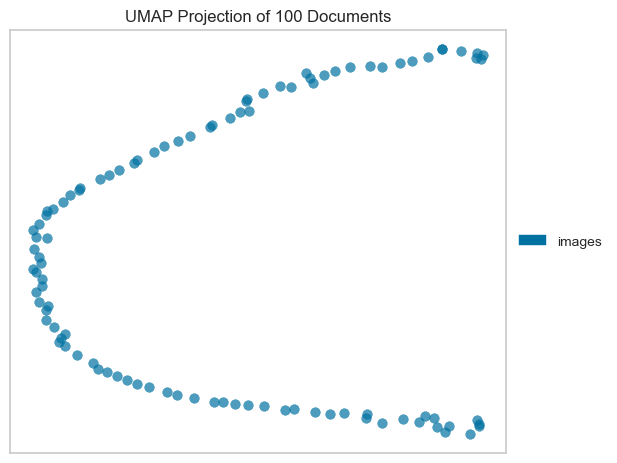

<AxesSubplot: title={'center': 'UMAP Projection of 100 Documents'}>

In [ ]:
from yellowbrick.text import UMAPVisualizer

umap = UMAPVisualizer(labels=["images"], metric='cosine')
umap.fit(X)
umap.show()

As expected, since the images form a sequence (because they are photos of the same patch of sun, spaced apart in time), their cosine similarities should be high between consecutive images. As such, they form a string like structure in the UMAP chart shown above. This patten alludes to their inherent sequential nature. 

## Image transformations using Albumentations

We will not use tensorflow for data-augmentation, it take too much time. We are using a third party library called albumentations. EfficientNet needs images in dimension 214x214x3.

In [ ]:
import albumentations as A
#https://albumentations.ai/docs/getting_started/image_augmentation/
# important to read
#https://albumentations.ai/docs/examples/example_kaggle_salt/ 

In [ ]:
# Defining the transformation function. Note this will wake an awway of images (batch x img_size) and perform the same transformation on it.
transform = A.ReplayCompose([
    A.CenterCrop(p=1, height=int(original_height*0.9), width=int(original_width*0.9)), #This is to remove the hardcoded timestamp in the lower left corner of image.
    # Crops to 1890x1890

    A.RandomCrop(width=224, height=224), #will randomly crop image to 224x224x3. 
    A.HorizontalFlip(p=0.5), #randomly flip horizontally.
    A.RandomBrightnessContrast(p=0.2), #randomly change brightness and contrast.
])

Now we are defining a convenience funciton to perform the abovementioned transformations on the batch of 100 images. This function would return an np.ndarray that contains all transformed images, with shape = (100, 224, 224, 3). 

Note: This function will randomly pick a transformation and apply the same transformation to ALL images in the batch.

In [ ]:
# random.seed(7)
def transform_image_list(list_original_image):
  data = transform(image=list_original_image[0])
  sample_image_list=[data['image']]
  for i in range(1,len(list_original_image)):
    image2_data = A.ReplayCompose.replay(data['replay'], image=list_original_image[i])
    sample_image_list=sample_image_list+[image2_data['image']]
  return np.array(sample_image_list)

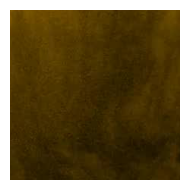

(224, 224, 3)


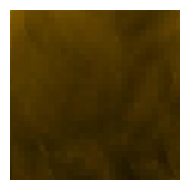

(224, 224, 3)


(100, 224, 224, 3)

In [ ]:
# Taking a look at two images. They should have the same transformation applied to them.
sample_image_list=transform_image_list(list_original_image)
display(sample_image_list[0])
display(sample_image_list[50])
sample_image_list.shape #shape of the transformed batch.

So now our transformation function works correctly. We can use it repeatedly to generate multiple transformed image-sets. 

## Embedding generation with EfficientNetV2L

In this section, we will use the power of transfer learning to generate embeddings for our image-sequence. We use a pre-trained EfficientNet and will use its penultimate layer (latent space) as the embedding. EfficientNetV2L works better/faster in our testing compared to EfficientNetB0.

EfficientNet outputs a convolution of size (batch_size x 7x7x1280). We compress that using maxpooling to an embedding of size (batch_size x 1280).

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L #works faster. 
#model = Sequantiel([
model=tf.keras.models.Sequential([
    EfficientNetV2L(include_top=False,weights='imagenet'),
    tf.keras.layers.GlobalAveragePooling2D(keepdims=False)
    ])
#model=EfficientNetV2L(include_top=True,weights='imagenet')
model.trainable = False

Metal device set to: Apple M1 Pro


2022-12-13 14:52:24.314747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-13 14:52:24.314868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Functiona  (None, None, None, 1280)  117746848
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 117,746,848
Trainable params: 0
Non-trainable params: 117,746,848
_________________________________________________________________


In [ ]:
# Defining convenience functions to save pickle files to disk.

# This function will take the image embedding set (100 batch x 100 images x 1280 embedding) to pickle
def write_sample(embedding_images,i):
    with open('/Users/loic/Library/CloudStorage/GoogleDrive-loic@baconnier.com/Mon Drive/AAA_NLP_UNIV.AI/SOLAR/Data/100_pics/embedding2/sample_embedding_'+str(i)+'.pkl', 'wb') as f:
        pickle.dump(embedding_images, f) 

# This function will take the image set (100 batch x 100 images x img_size = (224x224x3)) to pickle
# Use this carefully as this takes a HUGE amount of disk space. 
def write_sample2(embedding_images,i):
    with open('/Users/loic/Library/CloudStorage/GoogleDrive-loic@baconnier.com/Mon Drive/AAA_NLP_UNIV.AI/SOLAR/Data/100_pics/sample2/sample_'+str(i)+'.pkl', 'wb') as f:
        pickle.dump(embedding_images, f) 

Now we evaluate EfficientNetV2L on transformed set of 100 images to get sets of 100 embeddings. 

In [ ]:
%%time
#
#if False:
#samples=list(glob.glob('/Users/loic/Library/CloudStorage/GoogleDrive-loic@baconnier.com/Mon Drive/AAA_NLP_UNIV.AI/SOLAR/Data/100_pics/embedding2/sample_*.pkl'))
#last_index_sample=max([int(c.split('/')[-1].replace('sample_','').replace('.pkl',''))+1 for c in samples])+1
last_index_sample=70
print('we start a iteration: '+str(last_index_sample)) 
for s in range(1,100):
    embedding_images=[]
    sample_image_list=[]
    print('iteration: '+str(s))

    # This loop will run 100 times, making 100 different transformations to produce 100 (batch) sets of 100 (sequence) images. 
    # This is will predict embeddings using the model for each of these sequences. The output is a file of dimensions (batch = 100, seq = 100, emb = 1280)
    # Will save this file as a pickle for later use. 
    for i in range(0,100):
        sample_image=transform_image_list(list_original_image)
        sample_image_list=sample_image_list+[sample_image]
        embedding_images=embedding_images+[model.predict(sample_image,verbose=0)]
    embedding_images=np.squeeze(np.array(embedding_images))
    sample_image_list=np.array(sample_image_list)
    write_sample(embedding_images,s+last_index_sample)
    # Can also use the below function to save all cropped images of dimension (batch = 100, seq = 100, img = (224,224,3)).
    # Warning each file is huge.
    # write_sample2(sample_image_list,s) #use this carefully as this takes a HUGE amount of disk space. 

we start a iteration: 70
iteration: 1


2022-12-13 14:52:30.515086: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-13 14:52:31.630780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48


In [ ]:
for i in range(9):
	# define subplot
  pyplot.subplot(330 + 1 + i)
  # image=tf.image.random_crop(value=data_central_crop, size=(600, 600, 3))
  pyplot.imshow(list_original_image[i])
# show the figure
pyplot.show()
#!pip install yellowbrick
#!pip install umap-learn
np.array(list_original_image).reshape(100,-1).shape

X=np.array(list_original_image)
X=X.reshape(X.shape[0],-1)

y=['image_'+str(i) for i in range(X.shape[0])]
from yellowbrick.text import UMAPVisualizer

umap = UMAPVisualizer(labels=["images"], metric='cosine')
umap.fit(X)
umap.show()
X=model.predict(transform_image_list(list_original_image),verbose=0)
y=['image_'+str(i) for i in range(X.shape[0])]
umap = UMAPVisualizer(labels=["images"], metric='cosine')
umap.fit(X)
umap.show()

Now we try to use the same technique to reduce dimensions of the embeddings of the original set of 100 images and visualize them on the UMAP plane. We observe that the EfficientNet embeddings are localised but don't necessarily form a structural sequence in this visualization according to cosine similarity metric. This could be because our embeddings don't capture a lot of semantic information (of the images of the sun) because EfficientNet was trained originally on a different set of images. Some fine-tuning would improve results.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


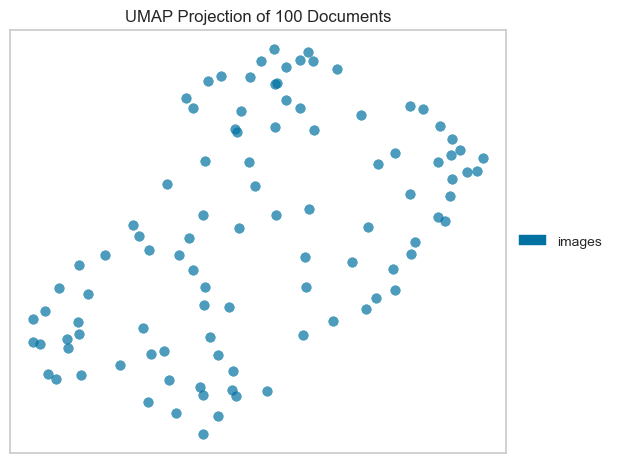

<AxesSubplot: title={'center': 'UMAP Projection of 100 Documents'}>

In [ ]:
X=model.predict(transform_image_list(list_original_image),verbose=0)
y=['image_'+str(i) for i in range(X.shape[0])]
umap = UMAPVisualizer(labels=["images"], metric='cosine')
umap.fit(X)
umap.show()

# Section 2: Model Training and Evaluation

In [ ]:
# Import necessary libraries
import time
import string
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras import backend as K
import glob
AUTOTUNE = tf.data.experimental.AUTOTUNE

We disable warning as we use mac to train

In [ ]:
import warnings
import logging
import os
warnings.filterwarnings('ignore')
def set_tf_loglevel(level):
    if level >= logging.FATAL:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    if level >= logging.ERROR:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    if level >= logging.WARNING:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    else:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
    logging.getLogger('tensorflow').setLevel(level)
set_tf_loglevel(logging.FATAL)

## Creation of Dataset

We work here on embeddings of images which have been generated by our EfficientNet encoder. We load all the embedding files from the directory. Note each file contains 100 sets of 100 image embeddings of dim 1280. We have ~100 files.

In [ ]:
directory='/Users/loic/Library/CloudStorage/GoogleDrive-loic@baconnier.com/Mon Drive/AAA_NLP_UNIV.AI/SOLAR/Data/100_pics/embedding2/'
list_samples=list(glob.glob(directory+'*.pkl'))
list_samples=list_samples

So we will have more than 10000 samples of all 100 embeddings for sequence of 100 images. Shape of combined corpus is (batch = 11300, seq = 100, emb = 1280). 

In [ ]:
emb_dataset=[]
for i in range(0,len(list_samples)-1):        
    image = pd.read_pickle(list_samples[i])
    emb_dataset=emb_dataset+[image]
emb_dataset=np.array(emb_dataset).reshape(-1,100,1280)
emb_dataset.shape

(11300, 100, 1280)

Here we decide the size of sequence (number of images), aka the **window length** which we will use to find next embedding. Let's say 10 images for the following comment. We will define a transformer function that will output a window of image embeddings for every sequence.

This funciton will help us generate the training and test data.

**We ran this notebook multiple times with window sizes = [10, 20, 50, 70]**

In [ ]:
#setting the window length.
sequence_length=20 #[10, 20, 50, 70]
embedding_dim=1280 #fixed, this is the size from Efficient Net

In [ ]:
### To do so we will take multiple samples of size 10 by creating multi random windows by randomizing the start point. 
# This function will give one seq of embeddings (shape = batch, seq length, emb_dim) and the next embedding (batch, emb_dim)
def window_process(emb_dataset):
    ran_i = np.random.randint(0, emb_dataset.shape[1]-sequence_length+1) #randomly select start idx.
    dataset=emb_dataset[:,ran_i:ran_i+sequence_length+1,:]
    return (dataset[:,:-1,:],dataset[:,-1,:])

toto=window_process(emb_dataset)
toto[0].shape,toto[1].shape

((11300, 20, 1280), (11300, 1280))

In [ ]:
### Let create a train and test dataset
from sklearn.model_selection import train_test_split
train_emb_dataset,test_emb_dataset=train_test_split(emb_dataset)
train_emb_dataset.shape

(8475, 100, 1280)

Generating a tf-dataset so that we don't have to load the whole set of embeddings in memory.

In [ ]:
# Set batch size  and train shuffle buffer size
batch_size = 128
train_shuffle_buffer_size = 1000

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(train_emb_dataset)
test_data = tf.data.Dataset.from_tensor_slices(test_emb_dataset)
train_data

Metal device set to: Apple M1 Pro


<TensorSliceDataset element_spec=TensorSpec(shape=(100, 1280), dtype=tf.float32, name=None)>

In [ ]:
# Apply all data processing logic

train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
train_data = train_data.map(window_process, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(AUTOTUNE)

test_data = test_data.shuffle(buffer_size=train_shuffle_buffer_size)
test_data = test_data.batch(batch_size)
test_data = test_data.map(window_process, num_parallel_calls=AUTOTUNE)
test_data = test_data.prefetch(AUTOTUNE)
print("train_data",train_data)

train_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, 20, 1280), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1280), dtype=tf.float32, name=None))>


We define our loss function and optimizer. And make a convenience funciton that will compile a model, train it on training data and have an early-stopping callback built in. 

Note. The embeddings generated by EfficientNet use a relu activation. That means the embeddings are non-negative unbounded. Also, since there is no "Vocabulary" of all possible unique images, we will convert the prediction of embedding into a regression problem and try to predict the next embedding as closely as possible. That means we can use MSE as loss function. 

**Now this makes a heavy assumption that embeddings of similar images are similar which still needs to be investigated.**



In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, train_data, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    restore_best_weights=True)
  # loss=tf.keras.metrics.MeanAbsoluteError()
  # We choose loss function as MSE because we will try to match the embeddings - regression problem.
  model.compile(optimizer='adam',loss='mse')
  history = model.fit(train_data,validation_data=test_data, epochs=MAX_EPOCHS,callbacks=[early_stopping])
  return history

## Creation of models

We will now use various deep learning models trained on our dataset and check their performance. The models will be kept simple for investigation purposes. The last layer will always be a dense layer with units = embedding dimension so that the model outputs an embedding (which we hope will be the next embedding in the series, checked using MSE as loss).
 

### Dummy model FFNN
We start the modelling process with the simplest model, a Feed Forward Neural Network (FFNN aka FCNN). We keep it simple and use dropout for regularization.

This model is expected to perform the worst.

Epoch 1/20


2022-12-14 15:35:31.045018: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


67/67 [==============================] - 3s 37ms/step - loss: 3.2016e-05 - val_loss: 0.0018
Epoch 2/20
67/67 [==============================] - 2s 27ms/step - loss: 1.2691e-05 - val_loss: 3.6286e-04
Epoch 3/20
67/67 [==============================] - 2s 26ms/step - loss: 4.7308e-06 - val_loss: 1.3010e-04
Epoch 4/20
67/67 [==============================] - 2s 25ms/step - loss: 2.2414e-06 - val_loss: 5.4923e-05
Epoch 5/20
67/67 [==============================] - 2s 26ms/step - loss: 1.7677e-06 - val_loss: 3.6506e-05
Epoch 6/20
67/67 [==============================] - 2s 25ms/step - loss: 1.2656e-06 - val_loss: 0.0010
Epoch 7/20
67/67 [==============================] - 2s 27ms/step - loss: 2.9947e-06 - val_loss: 8.6119e-05
Epoch 8/20
67/67 [==============================] - 2s 26ms/step - loss: 1.3208e-06 - val_loss: 4.1678e-05


<AxesSubplot: >

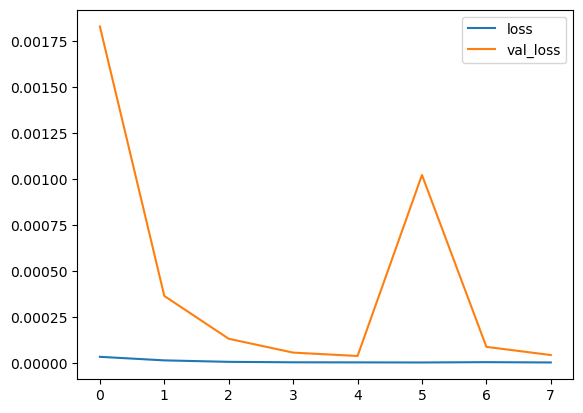

In [ ]:
FFNN_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=embedding_dim)
])
FFNN_history = compile_and_fit(FFNN_model, train_data)
pd.DataFrame(FFNN_history.history).plot()

### Simple RNN model

Now we make a model where the first layer is a simple RNN. This model is expected to perform slightly better but not as good as GRU/LSTM.

Epoch 1/20
67/67 [==============================] - 11s 163ms/step - loss: 3.7758e-05 - val_loss: 0.0016
Epoch 2/20
67/67 [==============================] - 11s 167ms/step - loss: 1.0784e-05 - val_loss: 7.7345e-05
Epoch 3/20
67/67 [==============================] - 12s 174ms/step - loss: 1.9671e-06 - val_loss: 4.8990e-05
Epoch 4/20
67/67 [==============================] - 12s 174ms/step - loss: 1.3977e-06 - val_loss: 4.5139e-05
Epoch 5/20
67/67 [==============================] - 12s 175ms/step - loss: 1.2624e-06 - val_loss: 3.5979e-05
Epoch 6/20
67/67 [==============================] - 12s 175ms/step - loss: 1.1501e-06 - val_loss: 4.8751e-05
Epoch 7/20
67/67 [==============================] - 12s 174ms/step - loss: 9.7011e-07 - val_loss: 2.8787e-05
Epoch 8/20
67/67 [==============================] - 12s 174ms/step - loss: 1.1387e-06 - val_loss: 1.0724e-04
Epoch 9/20
67/67 [==============================] - 12s 178ms/step - loss: 1.1717e-06 - val_loss: 9.4868e-05
Epoch 10/20
67/67 [====

<AxesSubplot: >

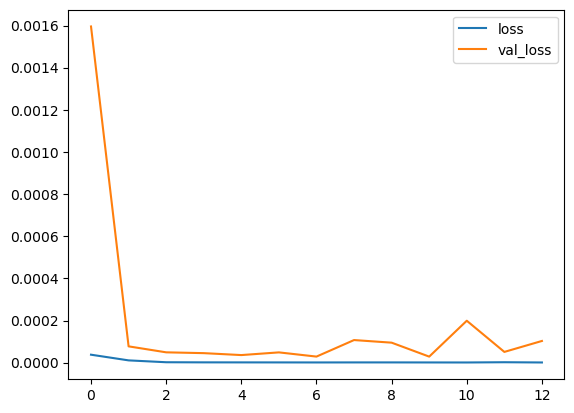

In [ ]:
RNN_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=False),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=embedding_dim)
])
RNN_history = compile_and_fit(RNN_model, train_data)
pd.DataFrame(RNN_history.history).plot()

### GRU model
Same philosophy as above. Performs slightly better than RNN.

Epoch 1/20
67/67 [==============================] - 3s 35ms/step - loss: 2.8360e-05 - val_loss: 4.4065e-04
Epoch 2/20
67/67 [==============================] - 2s 27ms/step - loss: 3.8950e-06 - val_loss: 8.2456e-05
Epoch 3/20
67/67 [==============================] - 2s 27ms/step - loss: 1.7343e-06 - val_loss: 3.6601e-05
Epoch 4/20
67/67 [==============================] - 2s 29ms/step - loss: 1.2890e-06 - val_loss: 3.2704e-05
Epoch 5/20
67/67 [==============================] - 2s 27ms/step - loss: 1.0529e-06 - val_loss: 2.7131e-05
Epoch 6/20
67/67 [==============================] - 2s 27ms/step - loss: 9.6085e-07 - val_loss: 2.4969e-05
Epoch 7/20
67/67 [==============================] - 2s 26ms/step - loss: 1.1783e-06 - val_loss: 1.9052e-04
Epoch 8/20
67/67 [==============================] - 2s 27ms/step - loss: 2.3377e-06 - val_loss: 5.8967e-04
Epoch 9/20
67/67 [==============================] - 2s 27ms/step - loss: 3.2535e-06 - val_loss: 1.2451e-04


<AxesSubplot: >

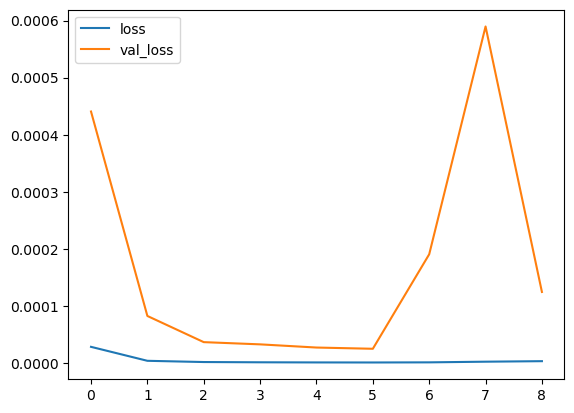

In [ ]:
GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(64, return_sequences=False),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=embedding_dim)
])
GRU_history = compile_and_fit(GRU_model, train_data)
pd.DataFrame(GRU_history.history).plot()

### LSTM model
We now make an LSTM model with 3 LSTM layers with expectation that this improves performace. Although this is expected to perform better than GRU, it only performs **slightly worse than GRU**.

Epoch 1/20
67/67 [==============================] - 6s 60ms/step - loss: 3.2859e-05 - val_loss: 0.0031
Epoch 2/20
67/67 [==============================] - 3s 45ms/step - loss: 2.9333e-05 - val_loss: 0.0010
Epoch 3/20
67/67 [==============================] - 3s 43ms/step - loss: 1.3148e-05 - val_loss: 3.8190e-04
Epoch 4/20
67/67 [==============================] - 3s 44ms/step - loss: 5.5785e-06 - val_loss: 2.5600e-04
Epoch 5/20
67/67 [==============================] - 3s 44ms/step - loss: 4.3428e-06 - val_loss: 1.6951e-04
Epoch 6/20
67/67 [==============================] - 3s 44ms/step - loss: 3.4373e-06 - val_loss: 1.4309e-04
Epoch 7/20
67/67 [==============================] - 3s 44ms/step - loss: 2.7411e-06 - val_loss: 2.5852e-04
Epoch 8/20
67/67 [==============================] - 3s 44ms/step - loss: 3.1757e-06 - val_loss: 5.0962e-05
Epoch 9/20
67/67 [==============================] - 3s 43ms/step - loss: 2.8554e-06 - val_loss: 3.8548e-05
Epoch 10/20
67/67 [==========================

<AxesSubplot: >

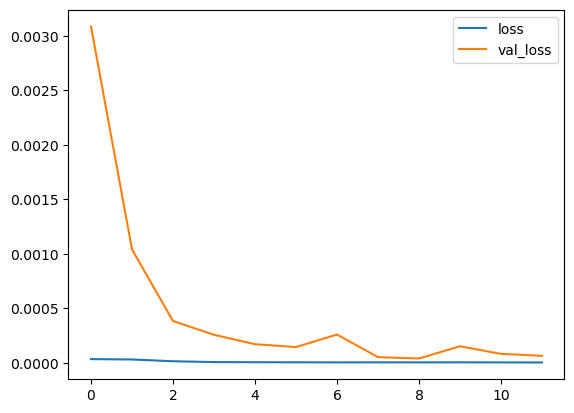

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=embedding_dim)
])

lstm_history = compile_and_fit(lstm_model, train_data)

pd.DataFrame(lstm_history.history).plot()
             

### Birirectionnal LSTM model
This time, we make a simple bidirectional LSTM model that utilizes 2 bidirectional layers. The bidirectional layers are made using the keras wrapper. The idea is that when an LSTM will scan the same sequence in both directions, it can get a better understanding and make better predictions.

Although in practice, we observed that it performed only slightly better than the vanilla LSTM model above and not as good as GRU, which is so-far the sweet and simple model. 

Epoch 1/20
67/67 [==============================] - 11s 112ms/step - loss: 3.2781e-05 - val_loss: 0.0031
Epoch 2/20
67/67 [==============================] - 6s 84ms/step - loss: 2.9303e-05 - val_loss: 0.0013
Epoch 3/20
67/67 [==============================] - 6s 83ms/step - loss: 1.2971e-05 - val_loss: 1.2158e-04
Epoch 4/20
67/67 [==============================] - 6s 83ms/step - loss: 6.9882e-06 - val_loss: 4.3931e-04
Epoch 5/20
67/67 [==============================] - 6s 83ms/step - loss: 5.2222e-06 - val_loss: 2.2981e-04
Epoch 6/20
67/67 [==============================] - 6s 86ms/step - loss: 3.9769e-06 - val_loss: 5.7535e-05
Epoch 7/20
67/67 [==============================] - 6s 86ms/step - loss: 3.0624e-06 - val_loss: 7.7467e-05
Epoch 8/20
67/67 [==============================] - 6s 86ms/step - loss: 3.1750e-06 - val_loss: 1.0253e-04
Epoch 9/20
67/67 [==============================] - 6s 88ms/step - loss: 2.7672e-06 - val_loss: 1.2019e-04


<AxesSubplot: >

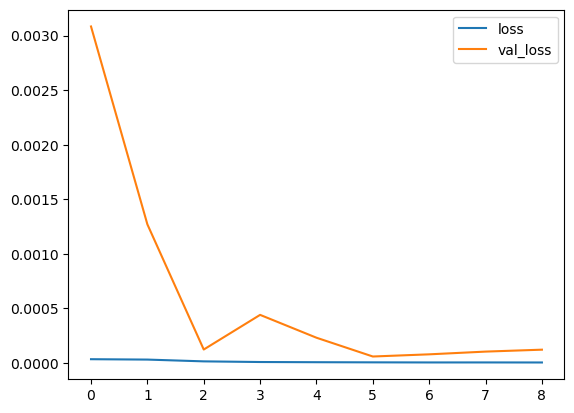

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=embedding_dim)
])

lstm_history = compile_and_fit(lstm_model, train_data)

pd.DataFrame(lstm_history.history).plot()
  

### A more complex model
Now we try to make a more complex bidirectional model but this time with bidirectional GRU (because it performed best above) sandwiching a bidirectional LSTM. This model seems to give **the best performance** because it's a mix of the simplicity of GRU and the flexibility of bidirectional scanning and LSTM. 

Epoch 1/20
67/67 [==============================] - 15s 163ms/step - loss: 3.0704e-05 - val_loss: 0.0013
Epoch 2/20
67/67 [==============================] - 8s 125ms/step - loss: 1.3756e-05 - val_loss: 1.9840e-04
Epoch 3/20
67/67 [==============================] - 8s 126ms/step - loss: 4.2822e-06 - val_loss: 4.1364e-05
Epoch 4/20
67/67 [==============================] - 8s 125ms/step - loss: 4.5214e-06 - val_loss: 8.0171e-04
Epoch 5/20
67/67 [==============================] - 8s 124ms/step - loss: 5.2839e-06 - val_loss: 5.4157e-05
Epoch 6/20
67/67 [==============================] - 8s 126ms/step - loss: 2.4530e-06 - val_loss: 6.4564e-05


<AxesSubplot: >

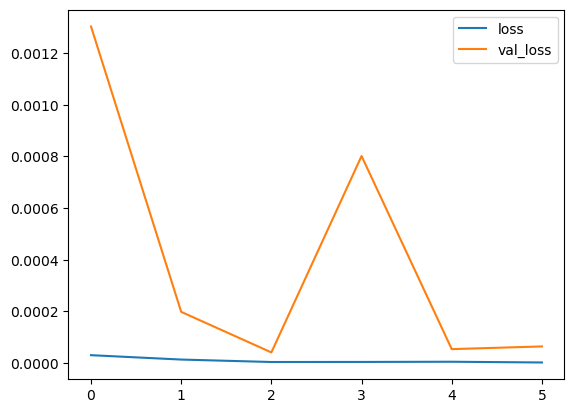

In [ ]:
Complex_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=embedding_dim)
])

Complex_history = compile_and_fit(Complex_model, train_data)

pd.DataFrame(Complex_history.history).plot()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 20, 256)          1082880   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 64)           73984     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 256)          148992    
 nal)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 64)                82176     
                                                                 
 dense_17 (Dense)            (None, 512)               33280     
                                                      

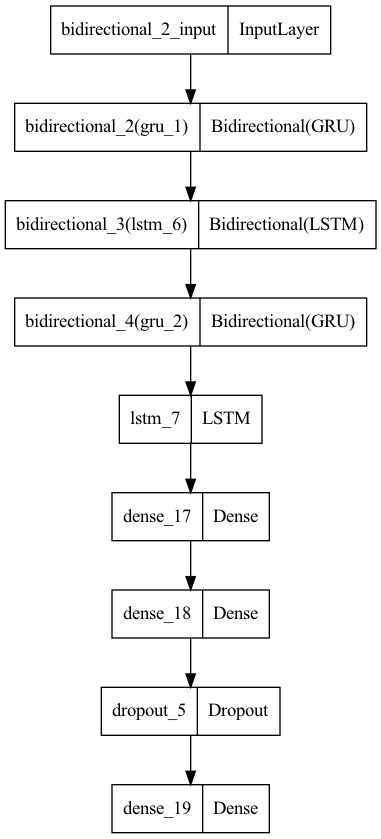

In [ ]:
# Taking a look at this model's summary and architecture.
Complex_model.summary()
tf.keras.utils.plot_model(Complex_model)

Since the complex model above has been the best performing so far, we show its performance on the test set. First we make predictions and then separate out the target (real) and predictions into a dataframe.

In [ ]:
nb=100
sample=toto[0][:nb]
real=toto[1][:nb]
predict=Complex_model.predict(sample)
np.reshape(predict,(-1,)).shape


4/4 [==============================] - 2s 150ms/step


(128000,)

In [ ]:
df=pd.DataFrame([np.reshape(real,(-1,)),np.reshape(predict,(-1,))]).T
df=df.rename(columns={0:'real',1:'prediction'})

Now we use the sns jointplot to show how the target and predicted embeddings compare to each other. If they are very similar, they would be very close to the x=y line. We are basically plotting all the coordinates of all the embeddings (1280 dimensions).

If we take a closer look at the difference between the predicted values and the real ones, we see that the predictions are rather good.
In the graphs below we have on the abscissa the values of the coordinates of the embedding vectors, and on the ordinate the predicted values.
We note that the dispersion around the line y=x is quite low, proof that the prediction is quite good.
Similarly, the distributions of these values are fairly close.

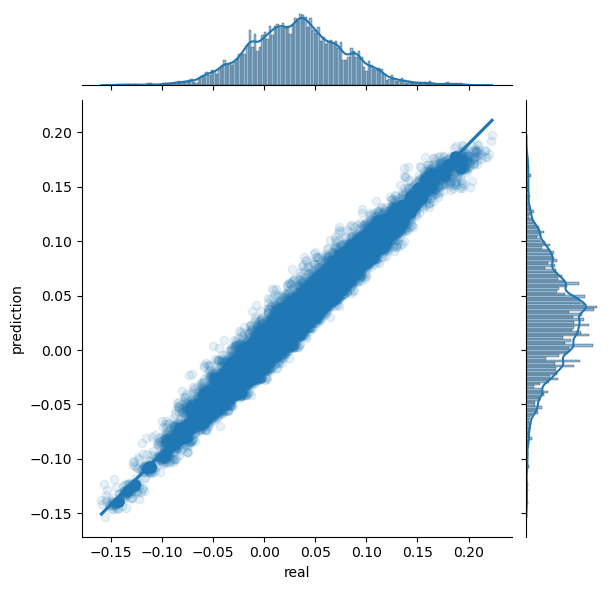

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from seaborn import pairplot
#plt.figure(figsize=(2,2))

sns.jointplot(x='real', y='prediction', data=df, kind="reg",joint_kws = {'scatter_kws':dict(alpha=0.1)})
#plt.title('Comparaison on all embedding space')
plt.savefig('Comparaison on all embedding space.png')

Here, we plot all the coordinates for just 2 selected embedding vectors, (#10 and #40. As can be seen here also, the embeddings (real and predicted) are pretty close and their distributions are pretty similar too. That means the complex model is working quite well. 

<Figure size 200x200 with 0 Axes>

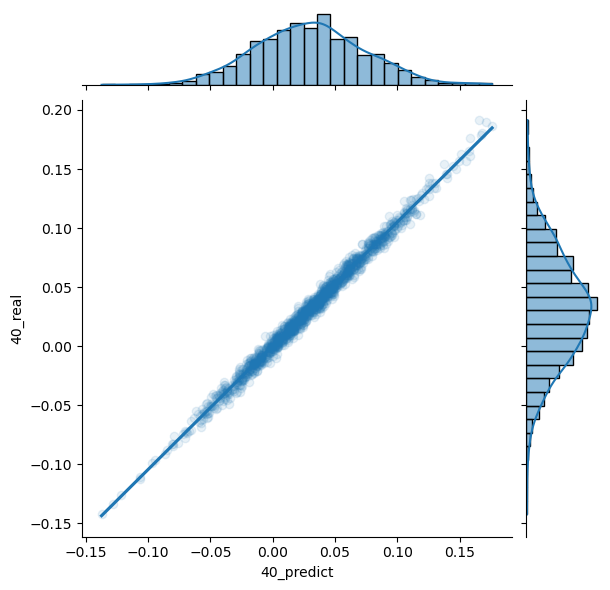

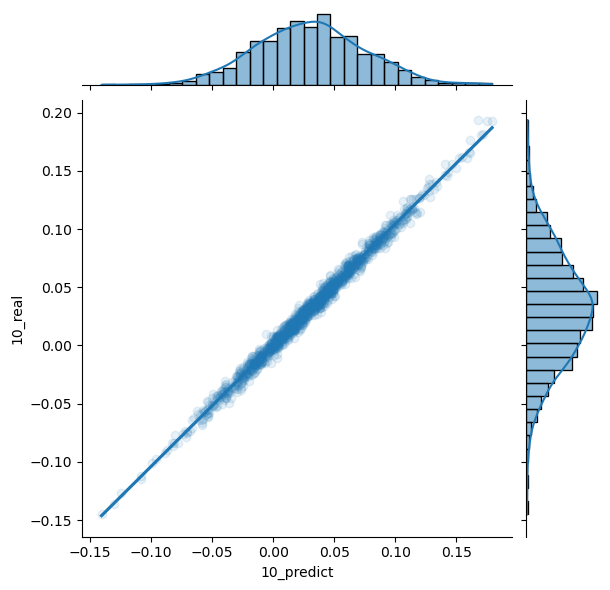

In [ ]:
col=[str(i)+'_real' for i in range(100)]+[str(i)+'_predict' for i in range(100)]
df=pd.DataFrame(np.concatenate([real,predict])).T
df.columns=col
df=df[sorted(col)]

import seaborn as sns
from seaborn import pairplot
plt.figure(figsize=(2,2))

sns.jointplot(x="40_predict", y="40_real", data=df, kind="reg",joint_kws = {'scatter_kws':dict(alpha=0.1)});
sns.jointplot(x="10_predict", y="10_real", data=df, kind="reg",joint_kws = {'scatter_kws':dict(alpha=0.1)});
plt.savefig('Comparaison on one embedding vector.png')

In [ ]:

#sns.lmplot(x="0_predict", y="0_real", data=df,
 #          lowess=True, line_kws={"color": "C1"});


# Section 2.5: Embedding -> Image with Autoencoder [Work in Progress]

In this section, we try to make an autoencoder that will convert the embeddings back into images. 

As we will see in this section, our simple decoder makes pretty terrible reconstructions (which is to be expected because the encoder we used above, i.e. EfficientNet is very complex and captures rich information inside the image. Our simple decoder is not flexible enough to reconstruct from such rich embeddings and we don't have the compute resources to train a more complex decoder). That is why this section is a **Work in Progress and its completion is part of the future scope of this project.**


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input,Dense,Reshape
from tensorflow.keras.models import Model
# from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
#import keras.applications.efficientnet_v2.EfficientNetV2B0 as EfficientNetV2B0
import tensorflow as tf
import glob as glob
import pandas as pd
import numpy as np
from matplotlib import pyplot
print("TF Version: ", tf.__version__)

TF Version:  2.10.0


Here we load all the 100 images and perform transformations on them to obtain cropped images of 224x224x3 dimensions. Since we have already done this when doing augmentation, we just pick up these images from the saved pickles.

In [ ]:

directory='/Users/loic/Library/CloudStorage/GoogleDrive-loic@baconnier.com/Mon Drive/AAA_NLP_UNIV.AI/SOLAR/Data/100_pics/samples/'
list_samples=list(glob.glob(directory+'*.pkl'))
len(list_samples)

12721

In [ ]:
sample=pd.read_pickle(list_samples[0])
sample.shape

(100, 224, 224, 3)

In [ ]:
%time
dataset=[]
# for i in range(1,len(list_samples)):        
for i in range(100,200):            
    if i%10==0:
        print('iteration: '+str(i))
    image = pd.read_pickle(list_samples[i])
    dataset=dataset+[image]
    # embedding_images=model.predict(image)
dataset=np.array(dataset).reshape(-1,224,224,3)
dataset.shape


CPU times: user 0 ns, sys: 1 µs, total: 1 µs
Wall time: 1.91 µs
iteration: 100
iteration: 110
iteration: 120
iteration: 130
iteration: 140
iteration: 150
iteration: 160
iteration: 170
iteration: 180
iteration: 190


(10000, 224, 224, 3)

Here we make a pipeline to feed the image data from the dataset above.

In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np   

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

from sklearn.model_selection import train_test_split
train_dataset,test_dataset=train_test_split(dataset)

  

train_gen = DataGenerator(train_dataset,train_dataset,  256)
test_gen = DataGenerator(test_dataset,test_dataset,  256)

Here we make the convolutional decoder. Remember, we use the EfifcientNet as the encoder and our decoder as the decoder in this autoencoder. We keep the decoder simple (because we can't make it more complex because of huge compute needed).

Our decoder blocks use convolution layers with same padding and uses a Conv2DTranspose layer to perform a deconvolution. We finally have a convolution layer with 3 filters and kernel size 1 and same padding to get a image of original size.

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
   
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def decoder_block(inputs, num_filters):

    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs) #deconvolution
    x = conv_block(x, num_filters)
    return x


In [ ]:
input_shape = (224, 224, 3)
latent_shape = (7, 7, 1280)
#latent_shape = (1,1280)
encoding_dim=1280

tf.keras.backend.clear_session()

input_encoder = Input(input_shape)

encoder = EfficientNetV2L(include_top=False, weights="imagenet", input_tensor=input_encoder)
encoder.trainable=False
encoder_output = encoder.get_layer("top_activation").output
latent_space = tf.keras.layers.GlobalAveragePooling2D(keepdims=False)(encoder_output)



Metal device set to: Apple M1 Pro


2022-12-15 08:27:14.872011: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-15 08:27:14.872738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
encoder = Model(input_encoder, latent_space)
# encoder.summary()

In [ ]:
encoder_input = Input(shape=(encoding_dim,))

decoder_input=tf.keras.layers.Dense(7*7*1280)(encoder_input)
decoder_input=tf.keras.layers.Reshape(latent_shape)(decoder_input)

d0 = decoder_block(decoder_input, 256)
d1 = decoder_block(d0, 128)
d2 = decoder_block(d1, 64)
d3 = decoder_block(d2, 32)
d4 = decoder_block(d3, 16)


outputs = Conv2D(3, 1, padding='same', activation="sigmoid",name='last_decoder_layer')(d4) #will yield original size image.

decoder = tf.keras.Model(encoder_input, outputs)


# decoder.summary()

In [ ]:
autoencoder = Model(input_encoder, decoder(encoder(input_encoder)), name="Solar_autoendecoder")
autoencoder.summary()

Model: "Solar_autoendecoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model (Functional)          (None, 1280)              117746848 
                                                                 
 model_1 (Functional)        (None, 224, 224, 3)       83405955  
                                                                 
Total params: 201,152,803
Trainable params: 83,403,971
Non-trainable params: 117,748,832
_________________________________________________________________


In [ ]:
autoencoder.compile(optimizer='adam',loss='binary_crossentropy') #since we want exact reconstruction, we use crossentropy loss.
# msle = tf.keras.losses.MeanSquaredLogarithmicError()
# autoencoder.compile(optimizer='rmsprop',loss=msle)

As we see below, this simple decoder also takes a huge amount of time to train and is not very good anyway.

In [ ]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)
autoencoder.fit(train_gen,validation_data=test_gen,callbacks=[early_stop],verbose=1,epochs=100)

Epoch 1/100


2022-12-15 08:27:22.843986: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-15 08:27:30.011348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6185

2022-12-15 08:31:37.667324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 306s 10s/step - loss: 0.6185 - val_loss: 0.6845
Epoch 2/100
30/30 [==============================] - 270s 9s/step - loss: 0.5537 - val_loss: 0.6629
Epoch 3/100
30/30 [==============================] - 258s 9s/step - loss: 0.5268 - val_loss: 0.6067
Epoch 4/100
30/30 [==============================] - 260s 9s/step - loss: 0.5085 - val_loss: 0.5601
Epoch 5/100
30/30 [==============================] - 278s 9s/step - loss: 0.4956 - val_loss: 0.5361
Epoch 6/100
30/30 [==============================] - 274s 9s/step - loss: 0.4845 - val_loss: 0.5107
Epoch 7/100
30/30 [==============================] - 276s 9s/step - loss: 0.4796 - val_loss: 0.5700
Epoch 8/100
30/30 [==============================] - 261s 9s/step - loss: 0.4706 - val_loss: 0.4970
Epoch 9/100
30/30 [==============================] - 266s 9s/step - loss: 0.4675 - val_loss: 0.4820
Epoch 10/100
30/30 [==============================] - 266s 9s/step - loss: 0.4646 - val_loss: 0.4713
Epoch 11/1

<AxesSubplot: >

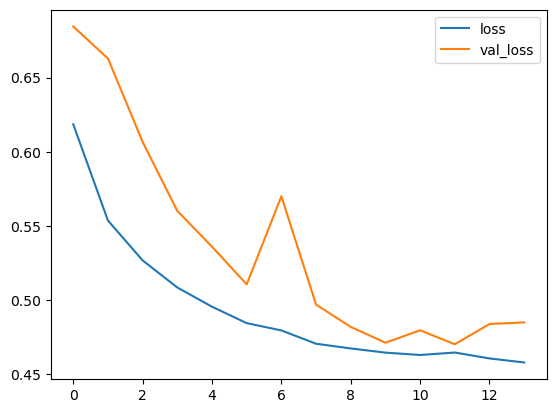

In [ ]:
pd.DataFrame(autoencoder.history.history).plot()

Here we check a sample reconstruction. As we can see, the features are not captured in the reconstruction at all. Only the colour scheme seems to match.

In [ ]:
image=autoencoder.predict(sample[:2])[1]

2022-12-15 09:35:05.986759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 13s 13s/step


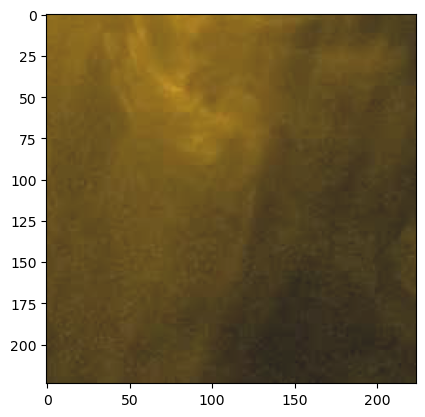

In [ ]:
pyplot.imshow(sample[1])

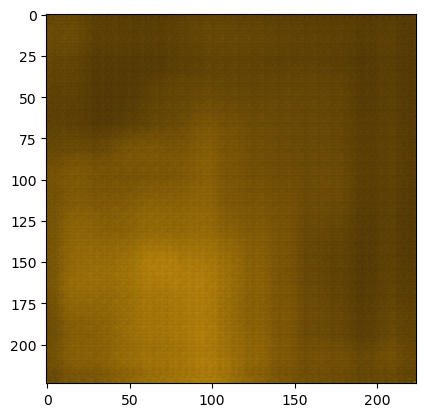

In [ ]:
pyplot.imshow(image)

In [ ]:
directory='/Users/loic/Library/CloudStorage/GoogleDrive-loic@baconnier.com/Mon Drive/AAA_NLP_UNIV.AI/SOLAR/Data/100_pics/models/'
autoencoder.save(directory+'autoencoder_model')

# Conclusion and Future Scope

As mentioned above, This project is aimed at providing a proof-of-concept of an architecture for unsupervised solar anomaly detection. With that in mind, we are currently working with very little data (Originally a 87 sec high resolution video of one patch of the sun’s surface 17 Earths wide) to demonstrate the idea.

With that in mind, there are a few things to note that flow into the future scope of this project:

* We used EfficientV2L, pretrained, to obtain embeddings for our solar images, exploting transfer learning and saving a lot of time. Although the embeddings are rich, they are not domain specific. This could mean that our embeddings don't capture a lot of semantic information (of the images of the sun) because EfficientNet was trained originally on a different set of images. Some fine-tuning would improve results.
* Since there is no "Vocabulary" of all possible unique images, we had no choice but to convert the prediction of embedding into a regression problem and try to predict the next embedding as closely as possible. While training our models for next embedding prediction, we chose MSE as loss function. This makes a heavy assumption that embeddings of similar images are similar which still needs to be investigated.
* The simple models trained performed surprisingly well and our complex model performed even better. The embeddings predicted matched pretty closely with the embeddings in reality. This was demonstrated with the jointplots. We tested their performance with multiple sequence lengths (window sizes) and tabulated the best epoch validation error (Root of MSE in 10^-5) as shown below:

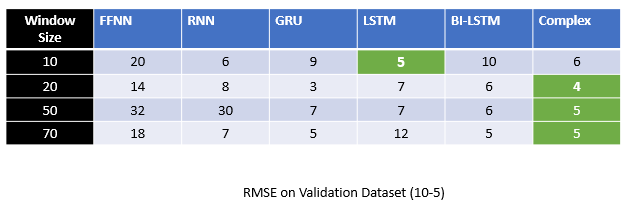

* We tried to train an autoencoder (decoder) for our EfficientNet encoder. Because of the huge compute needed, we had to settle with a fairly simple (compared to EfficientNet but still quite complex) decoder architecture which gave a pretty poor reconstruction performance. This can be developed further by making a more complicated decoder, for a start.


To further improve our model, we can develop a model based on transformers.
The state of the art would be to implement: ["Vision Transformers through Hierarchical Self-Supervised Learning"](https://arxiv.org/pdf/2206.02647.pdf)

Thank you!